# Importing Libraries

In [621]:
from scipy.spatial import distance_matrix
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
import copy
from pulp import *

In [622]:
# This function takes locations as input and plot a scatter plot
def plot_fig(dtfr,depot,heading="plot"):

    plt.figure(figsize=(10,10))
    for i,row in dtfr.iterrows():
        if dtfr.loc[i]["Location"]==depot:
            plt.scatter(row["Lat"],row["Long"],c='r')
            plt.text(row["Lat"]-0.0005, row["Long"]+0.0005, dtfr.loc[i]["Location"] + ' (depot) ')
        else:
            plt.scatter(row["Lat"], row["Long"], c='black')
            plt.text(row["Lat"] - 0.0005, row["Long"] + 0.0005,dtfr.loc[i]["Location"] )
        plt.ylim(82.968,83.03)
        plt.xlim(25.248,25.392)
        plt.ylabel("Longitude",fontsize = 15)
        plt.xlabel("Latitude",fontsize = 15)
        plt.title(heading,fontsize = 20)
        

# This function takes route plan as input and return the ordered routes and subtours, if present
def get_plan(r0,depot):
#     print()
    r=copy.copy(r0)
    for iter in range(len(r)):
        if(df.iloc[r[iter][0]]['Location']==depot):
            break
    route = []
    while len(r) != 0:
        plan = [r[iter]]
        del (r[iter])
        l = 0
        while len(plan) > l:
            l = len(plan)
            for i, j in enumerate(r):
                if plan[-1][1] == j[0]:
                    plan.append(j)
                    del (r[i])
        route.append(plan)
        iter = 0
    return(route)


In [623]:
df = pd.read_csv("Location Coordinates and Demand.csv")
df

,Location,Lat,Long,Demand
0,Mech dept,25.261696,82.991828,7
1,Sarnath,25.371556,83.025211,2
2,Sankat Mochan,25.285488,83.000301,5
3,VT BHU,25.266026,82.988330,2
4,Kashi Vishwanath Temple,25.308826,83.009428,7
5,Susuwahi,25.255879,82.974239,3
6,JHV mall,25.335669,82.977444,10
7,Lanka,25.281364,82.997783,8
8,Manduadih,25.296840,82.970123,2


In [624]:
dis_mat = pd.read_csv("Time Matrix.csv")   # This is actually Time Matrix not distance matrix
dis_mat

,Department of Mechanical Engineering,Sarnath,Sankat Mochan,Shri Kashi Vishwanath Temple,Shri Kashi Vishwanath Temple Dwar,Susuwahi,JHV Mall,Lanka,Manduadih Station
0,0,42,9,3,21,17,31,9,16
1,42,0,31,40,29,42,15,34,27
2,9,31,0,11,14,17,23,3,13
3,3,40,11,0,22,16,31,10,15
4,21,29,14,22,0,30,18,17,21
5,17,42,17,16,30,0,33,15,17
6,31,15,23,31,18,33,0,24,20
7,9,34,3,10,17,15,24,0,11
8,16,27,13,15,21,17,20,11,0


# Below is USER INPUT CELL

## User can change the no. of vehicles ( 2<=vehicles<=7)
## User can change the capacity of vehicle ( 10<=capacity<= infinite) (minimum capacity is 10 bcz minimum capacity of vehicle must be greater than or equal to maximum demand of any demand point)
## User can change the depot (choose from options given with correct spelling)

In [625]:
# Below are the choice of depot (type correct spelling)
df.Location

0                  Mech dept
1                    Sarnath
2              Sankat Mochan
3                     VT BHU
4    Kashi Vishwanath Temple
5                   Susuwahi
6                   JHV mall
7                      Lanka
8                  Manduadih
Name: Location, dtype: object

In [626]:
# THIS IS A USER INPUT CELL (change the values accordingly)

no_of_vehicles = 4  # 2<=vehicles<=7

depot = "Manduadih"  # available choices guven in previous cell

capacity = [15,15,15,15]  # 10<=capacity<=infinite

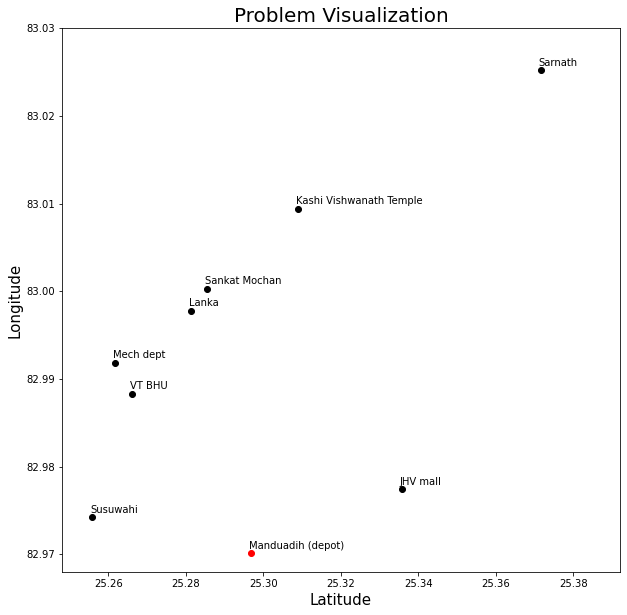

In [627]:
# Visualizing the problem


no_of_locs = len(df)  # 9
plot_fig(df,depot,heading="Problem Visualization") 
plt.show()

# Formulating the Problem

In [628]:
# Formulating the model
vrp = LpProblem('VRP Varanasi',LpMinimize)

C:\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [629]:
# Defining Variables
x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None for k in range(no_of_vehicles)]for j in range(no_of_locs)] for i in range(no_of_locs)]
# x

In [630]:
# Defining variable for " The fraction of the ith point demand delivered by the kth vehicle."
y = [[pulp.LpVariable(f"y{i}_{k}", cat="Continuous") for k in range(no_of_vehicles)] if (i != list(df['Location']).index(depot)) else None for i in range(no_of_locs)]
# y

In [631]:
# Defining the objective function

vrp += lpSum(dis_mat.iloc[i][j]*x[i][j][k] if (i!=j) else 0 for i in range(no_of_locs)\
                                   for j in range(no_of_locs) for k in range(no_of_vehicles))
# vrp

In [632]:
# Only one visit per location

for j in range(no_of_locs):
    vrp += lpSum(x[i][j][k] for i in range(no_of_locs) for k in range(no_of_vehicles)) >= 1

In [633]:
# No. of vehicle coming in and out of the location is same (Flow Conservation)

for j in range(no_of_locs):
    for k in range(no_of_vehicles):
        vrp += (lpSum(x[i][j][k] for i in range(no_of_locs))   \
                - lpSum(x[j][i][k] for i in range(no_of_locs)))==0

In [634]:
# Ensure that the demand of each demand point is fully met

for j in range(no_of_locs):
    if(j != list(df['Location']).index(depot)):
        vrp += lpSum(y[j][k] for k in range(no_of_vehicles)) == 1

In [635]:
# Ensure that the delivery assigned to every vehicle can't exceed its capacity

for k in range(no_of_vehicles):
    vrp += lpSum(y[j][k]*df["Demand"][j] if (j != list(df['Location']).index(depot)) else 0 for j in range(no_of_locs)) <= capacity[k]

In [636]:
# Each demand point can be serviced only by vehicle paasing through it

for k in range(no_of_vehicles):
    for j in range(no_of_locs):
        if (j != list(df['Location']).index(depot)):
            vrp += y[j][k] - lpSum(x[i][j][k] for i in range(no_of_locs)) <= 0

In [637]:
# Subtours Constraint

liss = list(range(no_of_locs))
liss.remove(liss[list(df['Location']).index(depot)])
for k in range(no_of_vehicles):
    subtours = []
    for i in range(2,no_of_locs):
         subtours += itertools.combinations((liss), i)

    for s in subtours:
        vrp += lpSum(x[i][j][k] if (i !=j) else 0 \
                     for i, j in itertools.permutations(s,2) \
                     for k in range(no_of_vehicles)) <= len(s) - 1
# subtours

In [638]:
# Non negativity constraint of y_j_k

for j in range(no_of_locs):
    if(j != list(df['Location']).index(depot)):
        for k in range(no_of_vehicles):
            vrp += y[j][k] >= 0

# Solving the problem and visualizing it

In [639]:
# Solving the model
for k in range(no_of_vehicles):
    if vrp.solve(GUROBI()) == 1:
        print('Vehicle Requirements:', no_of_vehicles)
        print('Moving Distance:', value(vrp.objective))
        break

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1109 rows, 320 columns and 58592 nonzeros
Model fingerprint: 0x2c3f3f6c
Variable types: 32 continuous, 288 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [3e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 471.0000000
Presolve removed 773 rows and 0 columns
Presolve time: 0.05s
Presolved: 336 rows, 320 columns, 15552 nonzeros
Variable types: 32 continuous, 288 integer (288 binary)
Found heuristic solution: objective 431.0000000

Root relaxation: objective 1.220000e+02, 132 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent  

In [640]:
# Printing the route of each vechicle

routes_of_all_vehicles = []
for k in range(no_of_vehicles):
    route = []
    for i in range(no_of_locs):
        for j in range(no_of_locs):
            if(i!=j and x[i][j][k].value()==1.0):
                route.append((i,j))
    routes_of_all_vehicles.append(get_plan(route,depot))
    
route_liss = []
for k in range(len(routes_of_all_vehicles)):
    ind_liss = []
    if(len(routes_of_all_vehicles[k])!=0):
        ind_liss.append(routes_of_all_vehicles[k][0][0][0])
        for rr in range(len(routes_of_all_vehicles[k][0])):
            ind_liss.append(routes_of_all_vehicles[k][0][rr][1])
        route_liss.append(ind_liss)
    else:
        route_liss.append(None)
        
for k in range(len(route_liss)):
    print(f"\nRoute of vehicle {k+1} is ----------------------------------------------------------------------------------\n")
    if(route_liss[k] != None):
        for r in range(len(route_liss[k])):
            if(r==len(route_liss[k])-1):
                print(df.iloc[route_liss[k][r]]['Location'],end="")
            else:
                print(df.iloc[route_liss[k][r]]['Location'],"---->",end="")
        print()
    else:
        print(None)   


Route of vehicle 1 is ----------------------------------------------------------------------------------

Manduadih ---->VT BHU ---->Mech dept ---->Lanka ---->Manduadih

Route of vehicle 2 is ----------------------------------------------------------------------------------

None

Route of vehicle 3 is ----------------------------------------------------------------------------------

Manduadih ---->Kashi Vishwanath Temple ---->Sankat Mochan ---->Lanka ---->Manduadih

Route of vehicle 4 is ----------------------------------------------------------------------------------

Manduadih ---->Sarnath ---->JHV mall ---->Susuwahi ---->Manduadih


In [641]:
# Printing the Total Time Taken by all vehicles along its route, Demand Supplied on its route, and Vehicle Capacity

demand_catered_all_vehicles = []
for k in range(no_of_vehicles):
    if(route_liss[k] is not None):
        dem = 0
        for r in range(len(route_liss[k])):
            j = route_liss[k][r]
            if(r!=0 and r != len(route_liss[k])-1):
                dem = dem + round(y[j][k].value()*df.iloc[j]["Demand"])
        demand_catered_all_vehicles.append(dem)
    else:
        demand_catered_all_vehicles.append(None)
all_vehicles_route_totaL_time_taken = []
for i,route_k in enumerate(routes_of_all_vehicles):
    total_time_taken_k = 0
    if(len(route_k)!=0):
        for tup in route_k[0]:
            total_time_taken_k += dis_mat.iloc[tup[0]][tup[1]]
        all_vehicles_route_totaL_time_taken.append(total_time_taken_k)
        print(f"For Vehicle {i+1} ------------------------------------------------------------------------------------------\n")
        print(f"Total time taken along its route is : {total_time_taken_k} || Total Demand Supplied : {demand_catered_all_vehicles[i]} || Vehicle Capacity : {capacity[i]}",end="\n\n")
    else:
        all_vehicles_route_totaL_time_taken.append(None)
        print(f"For Vehicle {i+1} ------------------------------------------------------------------------------------------\n")
        print(f"Total time taken along its route is : {None} || Total Demand Supplied : {None} || Vehicle Capacity : {capacity[i]}",end="\n\n")

For Vehicle 1 ------------------------------------------------------------------------------------------

Total time taken along its route is : 38 || Total Demand Supplied : 14 || Vehicle Capacity : 15

For Vehicle 2 ------------------------------------------------------------------------------------------

Total time taken along its route is : None || Total Demand Supplied : None || Vehicle Capacity : 15

For Vehicle 3 ------------------------------------------------------------------------------------------

Total time taken along its route is : 49 || Total Demand Supplied : 15 || Vehicle Capacity : 15

For Vehicle 4 ------------------------------------------------------------------------------------------

Total time taken along its route is : 92 || Total Demand Supplied : 15 || Vehicle Capacity : 15



In [642]:
# Creating DataFrame for output, 1st Column represent the demand of loaction, 2nd Column is name of location,
# rest are the demand fulfilled by vehicles (1 to 5) 

sol_liss = []
for j in range(no_of_locs):
    temp_liss = []
    if(j != list(df['Location']).index(depot)):
        temp_liss.append(df.iloc[j]["Demand"])
        temp_liss.append(df.iloc[j]["Location"])
        for k in range(no_of_vehicles):
            temp_liss.append(round(y[j][k].value()*df.iloc[j]["Demand"]))
        sol_liss.append(temp_liss)
sol_dict = dict()
sol_dict.update({'Demand':[],'Location':[]})
for k in range(no_of_vehicles):
    sol_dict.update({'Vehicle '+str(k+1) : []})
output_df = pd.DataFrame(sol_dict)
for i in range(len(sol_liss)):
    if(len(sol_liss[i])!=0):
        output_df.loc[len(output_df)] = sol_liss[i]
temp_liss = [None,depot+' (depot) ']
for k in range(no_of_vehicles):
    temp_liss.append(None)
output_df.loc[len(output_df)] = temp_liss
from datetime import datetime
dt = datetime.now()
output_df.to_csv(f'Output_data_{datetime.timestamp(dt)}.csv')
output_df

,Demand,Location,Vehicle 1,Vehicle 2,Vehicle 3,Vehicle 4
0,7,Mech dept,7,0,0,0
1,2,Sarnath,0,0,0,2
2,5,Sankat Mochan,0,0,5,0
3,2,VT BHU,2,0,0,0
4,7,Kashi Vishwanath Temple,0,0,7,0
5,3,Susuwahi,0,0,0,3
6,10,JHV mall,0,0,0,10
7,8,Lanka,5,0,3,0
8,None,Manduadih (depot),None,None,None,None


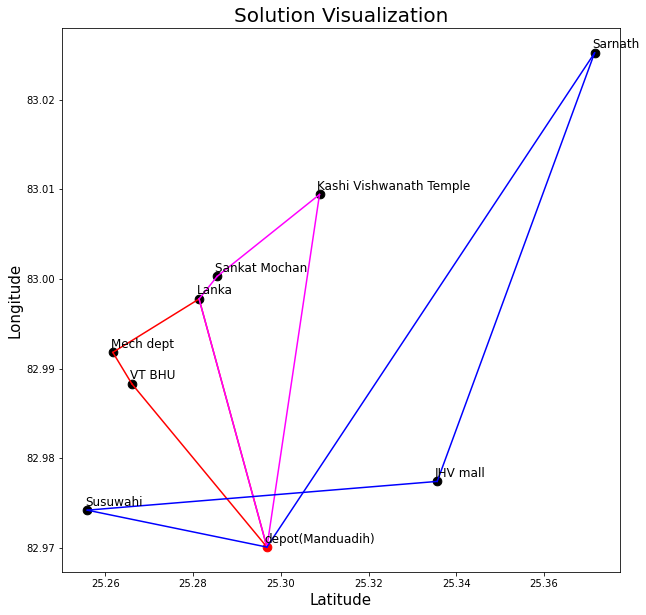

In [643]:
# Visualizing the solution
plt.figure(figsize=(10,10))
colors = ['red','green','magenta','blue','cyan','yellow','black']
for i in range(no_of_locs):    
    if df.loc[i]["Location"]==depot:
        plt.scatter(df.Lat[i], df.Long[i], c='red', s=75)
        plt.text(df.Lat[i]-0.0005, df.Long[i]+0.0005, "depot"+"("+depot+")", fontsize=12)
    else:
        plt.scatter(df.Lat[i], df.Long[i], c='black', s=75)
        plt.text(df.Lat[i]-0.0005, df.Long[i]+0.0005, df.loc[i]["Location"], fontsize=12)
        plt.ylabel("Longitude",fontsize = 15)
        plt.xlabel("Latitude",fontsize = 15)
        plt.title("Solution Visualization",fontsize = 20)
        
for k in range(no_of_vehicles):
    for i in range(no_of_locs):
        for j in range(no_of_locs):
            if i != j and pulp.value(x[i][j][k]) == 1.0:
                plt.plot([df.Lat[i], df.Lat[j]], [df.Long[i], df.Long[j]], c=colors[k])

# HENCE I conclude the SPLIT DELIVERY VRP Varanasi Solver